<a href="https://colab.research.google.com/github/AjaySreekumar47/vlm-research/blob/main/VLM_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/AviSoori1x/seemore.git
%cd seemore

Cloning into 'seemore'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 163 (delta 12), reused 9 (delta 8), pack-reused 147 (from 1)
Receiving objects: 100% (163/163), 20.46 MiB | 38.80 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/seemore/seemore


In [ ]:
import base64
import io
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import init

In [ ]:
# Ensure every computation happens on the GPU when available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#To build the encoding and decoding functions we use the tinyshakespear dataset. However for the sake of brevity we do not pretrain the decoder model on it
#the training function should be able to do it without an issue as well as it could take both images and tex
text_path = "./input.txt"
with open(text_path, 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
stoi['']= 65
itos = { i:ch for i,ch in enumerate(chars) }
itos[65] = ''
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
vocab_size = len(stoi.keys())

In [ ]:
class PatchEmbeddings(nn.Module):
    def __init__(self, img_size=96, patch_size=16, hidden_dim=512):
        super().__init__()

        # Store the input image size
        self.img_size = img_size

        # Store the size of each patch
        self.patch_size = patch_size

        # Calculate the total number of patches
        self.num_patches = (img_size // patch_size) ** 2

        # Create a convolutional layer to extract patch embeddings
        # in_channels=3 assumes the input image has 3 color channels (RGB)
        # out_channels=hidden_dim sets the number of output channels to match the hidden dimension
        # kernel_size=patch_size and stride=patch_size ensure each patch is separately embedded
        self.conv = nn.Conv2d(in_channels=3, out_channels=hidden_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, X):
        # Extract patch embeddings from the input image
        X = self.conv(X)

        # Flatten the spatial dimensions (height and width) of the patch embeddings
        # This step flattens the patch dimensions into a single dimension
        X = X.flatten(2)

        # Transpose the dimensions to obtain the shape [batch_size, num_patches, hidden_dim]
        # This step brings the num_patches dimension to the second position
        X = X.transpose(1, 2)

        return X

In [ ]:
#testing
img_size, patch_size,  num_hiddens, batch_size = 96, 16, 512, 4
patch_embeddings = PatchEmbeddings(img_size, patch_size, num_hiddens )
X = torch.zeros(batch_size, 3, img_size, img_size)
patch_embeddings(X).shape

torch.Size([4, 36, 512])

In [ ]:
#swapping linear for lazy linear for simplicity. Lazylinear can accept any arbitrary input dimension without having it specified

class MLP(nn.Module):
    def __init__(self, n_embd, dropout=0.1, is_decoder=True):
        super().__init__()

        # Define the layers of the MLP
        layers = [
            # First linear layer that expands the input dimension from n_embd to 4 * n_embd
            nn.Linear(n_embd, 4 * n_embd),

            # Activation function: ReLU if is_decoder is True, else GELU
            nn.ReLU() if is_decoder else nn.GELU(),

            # Second linear layer that projects the intermediate dimension back to n_embd
            nn.Linear(4 * n_embd, n_embd),

            # Dropout layer for regularization
            nn.Dropout(dropout)
        ]

        # Create a sequential container to hold the layers
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the MLP layers
        return self.net(x)

In [ ]:
#For the sake of this example consider embedding size to be 128
n_embd = 128
testmlp = MLP(n_embd)
mlp_input = torch.zeros(batch_size, 3, n_embd)
testmlp_out = testmlp(mlp_input)
testmlp_out.shape

torch.Size([4, 3, 128])

In [ ]:
class Head(nn.Module):
    def __init__(self, n_embd, head_size, dropout=0.1, is_decoder=False):
        super().__init__()

        # Linear layer for key projection
        self.key = nn.Linear(n_embd, head_size, bias=False)

        # Linear layer for query projection
        self.query = nn.Linear(n_embd, head_size, bias=False)

        # Linear layer for value projection
        self.value = nn.Linear(n_embd, head_size, bias=False)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Flag indicating whether this head is used in the decoder
        self.is_decoder = is_decoder

    def forward(self, x):
        # Get the batch size (B), sequence length (T), and embedding dimension (C) from the input tensor
        B, T, C = x.shape

        # Compute key, query, and value projections
        k = self.key(x)   # Shape: [B, T, head_size]
        q = self.query(x) # Shape: [B, T, head_size]
        v = self.value(x) # Shape: [B, T, head_size]

        # Compute attention scores by taking the dot product of query and key
        # and scaling by the square root of the embedding dimension
        wei = q @ k.transpose(-2, -1) * (C ** -0.5) # Shape: [B, T, T]

        if self.is_decoder:
            # If this head is used in the decoder, apply a causal mask to the attention scores
            # to prevent attending to future positions
            tril = torch.tril(torch.ones(T, T, dtype=torch.bool, device=x.device))
            wei = wei.masked_fill(tril == 0, float('-inf'))

        # Apply softmax to the attention scores to obtain attention probabilities
        wei = F.softmax(wei, dim=-1) # Shape: [B, T, T]

        # Apply dropout to the attention probabilities for regularization
        wei = self.dropout(wei)

        # Perform weighted aggregation of values using the attention probabilities
        out = wei @ v # Shape: [B, T, head_size]

        return out

In [ ]:
#Example values for testing
n_embd, head_size, batch_size = 128, 16, 4

testhead = Head(n_embd, head_size)
head_input = torch.zeros(batch_size, 3, n_embd)
testhead_out = testhead(head_input)
testhead_out.shape # (B, T,H_size)

torch.Size([4, 3, 16])

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, num_heads, dropout=0.1, is_decoder=False):
        super().__init__()

        # Ensure that the embedding dimension is divisible by the number of heads
        assert n_embd % num_heads == 0, "n_embd must be divisible by num_heads"

        # Create a ModuleList of attention heads
        self.heads = nn.ModuleList([
            Head(n_embd, n_embd // num_heads, dropout, is_decoder)
            for _ in range(num_heads)
        ])

        # Linear layer for projecting the concatenated head outputs
        self.proj = nn.Linear(n_embd, n_embd)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Apply each attention head to the input tensor
        head_outputs = [h(x) for h in self.heads]

        # Concatenate the outputs from all heads along the last dimension
        out = torch.cat(head_outputs, dim=-1)

        # Apply the projection layer to the concatenated outputs
        out = self.proj(out)

        # Apply dropout to the projected outputs for regularization
        out = self.dropout(out)

        return out

In [ ]:
#Example values for testing
n_embd, n_head = 128, 8
testmha = MultiHeadAttention(n_embd, n_head)
head_input = torch.zeros(batch_size, 3, n_embd)
testmha_out = testmha(head_input)
testmha_out.shape # (B, T,H_size*n_heads = n_embed)

torch.Size([4, 3, 128])

In [ ]:
class Block(nn.Module):
    def __init__(self, n_embd, num_heads, dropout=0.1, is_decoder=False):
        super().__init__()

        # Layer normalization for the input to the attention layer
        self.ln1 = nn.LayerNorm(n_embd)

        # Multi-head attention module
        self.attn = MultiHeadAttention(n_embd, num_heads, dropout, is_decoder)

        # Layer normalization for the input to the FFN
        self.ln2 = nn.LayerNorm(n_embd)

        # Feed-forward neural network (FFN)
        self.ffn = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # Expand the dimension
            nn.GELU(),  # Activation function
            nn.Linear(4 * n_embd, n_embd),  # Project back to the original dimension
        )

    def forward(self, x):
        original_x = x  # Save the input for the residual connection

        # Apply layer normalization to the input
        x = self.ln1(x)

        # Apply multi-head attention
        attn_output = self.attn(x)

        # Add the residual connection (original input) to the attention output
        x = original_x + attn_output

        # Apply layer normalization to the input to the FFN
        x = self.ln2(x)

        # Apply the FFN
        ffn_output = self.ffn(x)

        # Add the residual connection (input to FFN) to the FFN output
        x = x + ffn_output

        return x

In [ ]:
#Example values for testing
n_embd, head_size, batch_size = 128, 16, 4

testblock = Block(n_embd, n_head)
block_input = torch.zeros(batch_size, 3, n_embd)
testblock_out = testblock(block_input)
testblock_out.shape

torch.Size([4, 3, 128])

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout):
        super().__init__()

        # Patch embedding layer to convert the input image into patches
        self.patch_embedding = PatchEmbeddings(img_size, patch_size, num_hiddens)

        # Learnable classification token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))

        # Calculate the number of patches
        num_patches = (img_size // patch_size) ** 2

        # Learnable position embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, num_hiddens))

        # Dropout layer for the embeddings
        self.dropout = nn.Dropout(emb_dropout)

        # Stack of transformer blocks
        self.blocks = nn.ModuleList([Block(num_hiddens, num_heads, blk_dropout, is_decoder=False) for _ in range(num_blks)])

        # Layer normalization for the final representation
        self.layer_norm = nn.LayerNorm(num_hiddens)

    def forward(self, X):
        # Convert the input image into patch embeddings
        x = self.patch_embedding(X)

        # Expand the classification token to match the batch size
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)

        # Concatenate the classification token with the patch embeddings
        x = torch.cat((cls_tokens, x), dim=1)

        # Add the position embedding to the patch embeddings
        x += self.pos_embedding

        # Apply dropout to the embeddings
        x = self.dropout(x)

        # Pass the embeddings through the transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply layer normalization to the final representation
        x = self.layer_norm(x[:, 0])

        return x

In [ ]:
#For purposes of testing
img_size, patch_size, num_hiddens, n_head, num_blks, dropout = 96, 16, 512, 8, 3, 0.1

testvit = ViT(img_size, patch_size, num_hiddens, n_head, num_blks, dropout, dropout)
vit_input = torch.zeros(batch_size, 3, img_size, img_size)
testvit_out = testvit(vit_input)
testvit_out.shape

torch.Size([4, 512])

In [ ]:
class MultiModalProjector(nn.Module):
    def __init__(self, n_embd, image_embed_dim, dropout=0.1):
        super().__init__()

        # Define the projection network
        self.net = nn.Sequential(
            # Linear layer to expand the image embedding dimension
            nn.Linear(image_embed_dim, 4 * image_embed_dim),

            # GELU activation function
            nn.GELU(),

            # Linear layer to project the expanded image embeddings to the text embedding dimension
            nn.Linear(4 * image_embed_dim, n_embd),

            # Dropout layer for regularization
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Pass the input through the projection network
        x = self.net(x)
        return x

In [ ]:
#Example values for testing
n_embd,num_hiddens = 128, 512

testmmp = MultiModalProjector(n_embd,num_hiddens)
mmp_input = testvit_out
testmmp_out = testmmp(mmp_input)
testmmp_out.shape

torch.Size([4, 128])

In [ ]:
class DecoderLanguageModel(nn.Module):
    def __init__(self, n_embd, image_embed_dim, vocab_size, num_heads, n_layer, use_images=False):
        super().__init__()

        self.use_images = use_images

        # Token embedding table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)

        # Position embedding table
        self.position_embedding_table = nn.Embedding(1000, n_embd)

        if use_images:
            # Image projection layer to align image embeddings with text embeddings
            self.image_projection = MultiModalProjector(n_embd, image_embed_dim)

        # Stack of transformer decoder blocks
        self.blocks = nn.Sequential(*[Block(n_embd, num_heads, is_decoder=True) for _ in range(n_layer)])

        # Final layer normalization
        self.ln_f = nn.LayerNorm(n_embd)

        # Language modeling head
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, image_embeds=None, targets=None):
        # Get token embeddings from the input indices
        tok_emb = self.token_embedding_table(idx)

        if self.use_images and image_embeds is not None:
            # Project and concatenate image embeddings with token embeddings
            img_emb = self.image_projection(image_embeds).unsqueeze(1)
            tok_emb = torch.cat([img_emb, tok_emb], dim=1)

        # Get position embeddings
        pos_emb = self.position_embedding_table(torch.arange(tok_emb.size(1), device=device)).unsqueeze(0)

        # Add position embeddings to token embeddings
        x = tok_emb + pos_emb

        # Pass through the transformer decoder blocks
        x = self.blocks(x)

        # Apply final layer normalization
        x = self.ln_f(x)

        # Get the logits from the language modeling head
        logits = self.lm_head(x)

        if targets is not None:
            if self.use_images and image_embeds is not None:
                # Prepare targets by concatenating a dummy target for the image embedding
                batch_size = idx.size(0)
                targets = torch.cat([torch.full((batch_size, 1), -100, dtype=torch.long, device=device), targets], dim=1)

            # Compute the cross-entropy loss
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-100)
            return logits, loss

        return logits

    def generate(self, idx, image_embeds, max_new_tokens):
        # Get the batch size and sequence length
        B, T = idx.shape

        # Initialize the generated sequence with the input indices
        generated = idx

        if self.use_images and image_embeds is not None:
            # Project and concatenate image embeddings with token embeddings
            img_emb = self.image_projection(image_embeds).unsqueeze(1)
            current_output = torch.cat([img_emb, self.token_embedding_table(idx)], dim=1)
        else:
            current_output = self.token_embedding_table(idx)

        # Generate new tokens iteratively
        for i in range(max_new_tokens):
            # Get the current sequence length
            T_current = current_output.size(1)

            # Get position embeddings for the current sequence length
            current_pos_emb = self.position_embedding_table(torch.arange(T_current, device=device)).unsqueeze(0)

            # Add position embeddings to the current output
            current_output += current_pos_emb

            # Pass through the transformer decoder blocks
            for block in self.blocks:
                current_output = block(current_output)

            # Get the logits for the last token
            logits = self.lm_head(current_output[:, -1, :])

            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample the next token based on the probabilities
            idx_next = torch.multinomial(probs, num_samples=1)

            # Concatenate the generated token to the generated sequence
            generated = torch.cat((generated, idx_next), dim=1)

            # Get the embeddings for the generated token
            idx_next_emb = self.token_embedding_table(idx_next)

            # Concatenate the generated token embeddings to the current output
            current_output = torch.cat((current_output, idx_next_emb), dim=1)

        return generated

In [ ]:
# I use n_layer to represent number of decoder transformer blocks and n_blks for the vision encoder to avoid confusion
model = DecoderLanguageModel(n_embd=128, image_embed_dim=256, vocab_size=1000, num_heads=8, n_layer=6, use_images=True)
model.to(device)
# Dummy input
B, T = 10, 50
idx = torch.randint(0, 1000, (B, T)).to(device)
image_embeds = torch.randn(B, 256).to(device)  # Assume image_embed_dim is 256

targets = torch.randint(0, vocab_size, (B, T)).to(device)  # Only if you want to compute loss

# Test forward pass
# Check if you need to calculate loss by providing targets
if targets is not None:
    logits, loss = model(idx, image_embeds, targets)
    print(f"Logits shape: {logits.shape}, Loss: {loss}")
else:
    logits = model(idx, image_embeds)  # Call without targets
    print(f"Logits shape: {logits.shape}")

# Test generation
generated = model.generate(idx, image_embeds, max_new_tokens=20)
print(f"Generated sequence shape: {generated.shape}")

Logits shape: torch.Size([10, 51, 1000]), Loss: 7.06925630569458
Generated sequence shape: torch.Size([10, 70])


In [ ]:
class VisionLanguageModel(nn.Module):
    def __init__(self, n_embd, image_embed_dim, vocab_size, n_layer, img_size, patch_size, num_heads, num_blks, emb_dropout, blk_dropout):
        super().__init__()

        # Set num_hiddens equal to image_embed_dim
        num_hiddens = image_embed_dim

        # Assert that num_hiddens is divisible by num_heads
        assert num_hiddens % num_heads == 0, "num_hiddens must be divisible by num_heads"

        # Initialize the vision encoder (ViT)
        self.vision_encoder = ViT(img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout)

        # Initialize the language model decoder (DecoderLanguageModel)
        self.decoder = DecoderLanguageModel(n_embd, image_embed_dim, vocab_size, num_heads, n_layer, use_images=True)

    def forward(self, img_array, idx, targets=None):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)

        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")

        if targets is not None:
            # If targets are provided, compute the logits and loss
            logits, loss = self.decoder(idx, image_embeds, targets)
            return logits, loss
        else:
            # If targets are not provided, compute only the logits
            logits = self.decoder(idx, image_embeds)
            return logits

    def generate(self, img_array, idx, max_new_tokens):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)

        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")

        # Generate new tokens using the language model decoder
        generated_tokens = self.decoder.generate(idx, image_embeds, max_new_tokens)
        return generated_tokens

In [ ]:
image_embed_dim = num_hiddens
n_layer, block_size =  8, 32

# Initialize the model
model = VisionLanguageModel(n_embd, image_embed_dim, vocab_size,  n_layer, img_size, patch_size, n_head, num_blks, dropout, dropout)
model.to(device)

# Create dummy data with correct dimensions
dummy_img = torch.randn(1, 3, img_size, img_size).to(device)  # Correct shape for image input
dummy_idx = torch.randint(0, vocab_size, (1, block_size)).to(device)  # Correct shape for text input

# Forward pass to initialize all parameters
try:
    output = model(dummy_img, dummy_idx)  # Output for debugging
    print("Output from initialization forward pass:", output)
except RuntimeError as e:
    print(f"Runtime Error during forward pass: {str(e)}")
    print("Check layer configurations and input shapes.")

Output from initialization forward pass: tensor([[[-0.5056, -0.5616,  0.1827,  ...,  0.3703, -1.1181, -1.1327],
         [ 0.1389, -0.3426, -0.5013,  ...,  0.1491, -0.4181, -0.3508],
         [ 0.0278,  0.0738, -0.1515,  ..., -0.5447,  0.1003, -1.0043],
         ...,
         [ 0.2005,  0.7690, -0.0598,  ...,  0.4346, -0.2415, -0.7684],
         [-0.1771,  0.8355, -0.6702,  ...,  0.5285,  0.8346, -0.9312],
         [-0.2213,  0.1512,  0.7856,  ..., -0.0038,  0.1175, -0.0896]]],
       device='cuda:0', grad_fn=<ViewBackward0>)


In [ ]:
def base64_to_tensor(base64_str, img_size=96):
    image = Image.open(io.BytesIO(base64.b64decode(base64_str)))
    if image.mode != 'RGB':
        image = image.convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

In [ ]:
#Adjusting the data loader from makemore for multimodal data
def get_batch(df, batch_size, split='train', img_size=96, val_batch_size=8):
    # Split data into training and validation sets
    n = int(0.9 * len(df))  # first 90% will be train, rest val
    df_train = df.iloc[:n]
    df_val = df.iloc[n:]
    data = df_train if split == 'train' else df_val
    batch_size = batch_size if split == 'train' else val_batch_size
    replace = False if split == 'train' else True
    batch = data.sample(n=batch_size, replace=replace)

    images = torch.cat([base64_to_tensor(img, img_size) for img in batch['b64string_images']], dim=0).to(device)
    text_indices = [torch.tensor(encode(desc), dtype=torch.long) for desc in batch['caption']]
    max_length = max(len(t) for t in text_indices)

    padded_text = torch.full((batch_size, max_length), fill_value=stoi[''], dtype=torch.long).to(device)
    for i, text in enumerate(text_indices):
        padded_text[i, :len(text)] = text

    targets = torch.cat([padded_text[:, 1:], torch.full((batch_size, 1), fill_value=stoi[''], dtype=torch.long, device=device)], dim=1)

    # Truncate or pad targets to match the length of padded_text
    if targets.size(1) > padded_text.size(1):
        targets = targets[:, :padded_text.size(1)]
    elif targets.size(1) < padded_text.size(1):
        targets = torch.cat([targets, torch.full((batch_size, padded_text.size(1) - targets.size(1)), fill_value=stoi[''], dtype=torch.long, device=device)], dim=1)

    return images, padded_text, targets

In [ ]:
#Adjusting the training loop from makemore for multimodal data
def train_model(model, df, epochs, vocab_size, img_size=96):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for _ in range(max_iters):
            images, idx, targets = get_batch(df, batch_size, 'train', img_size)
            optimizer.zero_grad()
            logits, loss = model(images, idx, targets)
            loss.backward()
            optimizer.step()
            if _ % eval_interval == 0:
                print(f"Loss at iteration {_}: {loss.item()}")
        val_loss = estimate_loss(model, df, 'val', img_size, val_batch_size=8)
        print(f"Validation Loss after epoch {epoch}: {val_loss}")

def estimate_loss(model, df, split, img_size=96, val_batch_size=8):
    losses = []
    model.eval()
    for _ in range(eval_iters):
        images, idx, targets = get_batch(df, batch_size, split, img_size, val_batch_size=val_batch_size)
        _, loss = model(images, idx, targets)
        losses.append(loss.item())
    return sum(losses) / len(losses)

In [ ]:
df = pd.read_csv("/content/seemore/images/inputs.csv")
#Expanding dataframe so that there's enough data to test. This is just duplicating data. A real dataset would have more rows
df = pd.concat([df] * 30)[['b64string_images', 'caption']]
df.shape

(90, 2)

In [ ]:
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 100
eval_interval = 10
learning_rate = 1e-3
epochs=40
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 40
num_blks= 3
head_size = 16
n_embd = 128
n_head = 8
n_layer = 8
dropout = 0.1
img_size=96
patch_size =16
image_embed_dim = 512
emb_dropout = blk_dropout =0.1

In [ ]:
# Initialize the model
model = VisionLanguageModel(n_embd, image_embed_dim, vocab_size, n_layer, img_size, patch_size, n_head, num_blks, emb_dropout, blk_dropout)
model.to(device)

# Dummy data to initialize lazy modules
dummy_img = torch.randn(1, 3, img_size, img_size).to(device)
dummy_idx = torch.randint(0, vocab_size, (1, block_size)).to(device)
model(dummy_img, dummy_idx)  # Forward pass to initialize all parameters

# Train the model
train_model(model, df, epochs, vocab_size, img_size)

Loss at iteration 0: 4.41386604309082
Loss at iteration 10: 0.4361114799976349
Loss at iteration 20: 0.08940304070711136
Loss at iteration 30: 0.03451789915561676
Loss at iteration 40: 0.03136470913887024
Loss at iteration 50: 0.0663377121090889
Loss at iteration 60: 0.030136365443468094
Loss at iteration 70: 0.02541194297373295
Loss at iteration 80: 0.02579871378839016
Loss at iteration 90: 0.02053493820130825
Validation Loss after epoch 0: 0.019220658903941513
Loss at iteration 0: 0.021029116585850716
Loss at iteration 10: 0.01518691424280405
Loss at iteration 20: 0.017758220434188843
Loss at iteration 30: 0.021676845848560333
Loss at iteration 40: 0.02509402483701706
Loss at iteration 50: 0.020546436309814453
Loss at iteration 60: 0.021350212395191193
Loss at iteration 70: 0.02213570661842823
Loss at iteration 80: 0.018320726230740547
Loss at iteration 90: 0.017286349087953568
Validation Loss after epoch 1: 0.01677002403885126
Loss at iteration 0: 0.02002651058137417
Loss at iterati

## Testing out model

Image Captioning – Give it a new image → get a caption.

Multimodal Autoregressive Generation – Seed it with an image and a partial caption → it completes the caption.

Visual Prompt Completion – Start with "A picture of" → model fills in the rest based on the image.

In [ ]:
def test_model_on_image(model, base64_str, max_new_tokens=30):
    model.eval()

    # Convert base64 image to tensor
    image_tensor = base64_to_tensor(base64_str, img_size=img_size).to(device)

    # Start with an empty prompt or a beginning prompt like "A picture of"
    start_prompt = "A picture of"
    input_idx = torch.tensor([encode(start_prompt)], dtype=torch.long).to(device)

    # Generate text from the image + prompt
    with torch.no_grad():
        generated_idx = model.generate(image_tensor, input_idx, max_new_tokens=max_new_tokens)

    # Decode output
    decoded_caption = decode(generated_idx[0].tolist())

    print("Input Prompt:", start_prompt)
    print("Generated Caption:", decoded_caption)

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt

def show_image_from_base64(base64_str):
    image = Image.open(io.BytesIO(base64.b64decode(base64_str)))
    if image.mode != 'RGB':
        image = image.convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title("Decoded Image from Base64")
    plt.show()

    return image  # In case you want to save or reuse it

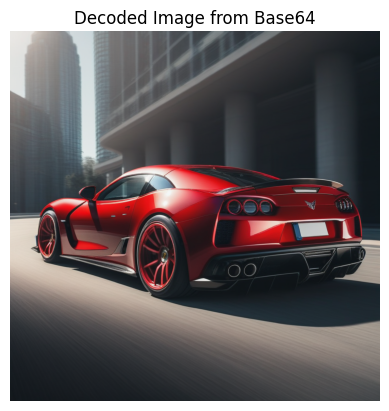

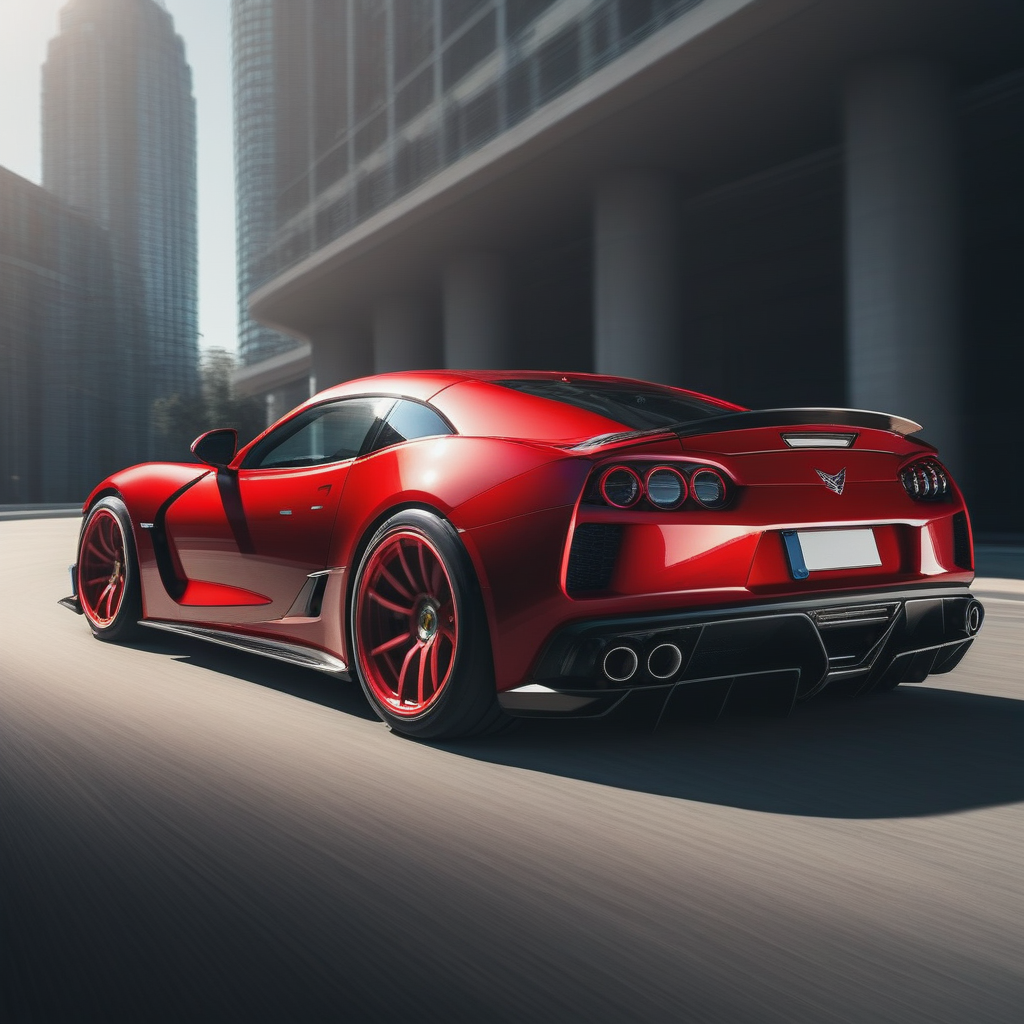

In [ ]:
# Select a sample from your DataFrame
sample_row = df.iloc[0]
sample_base64 = sample_row['b64string_images']

# Display the image
show_image_from_base64(sample_base64)

In [ ]:
# Pick a row from your dataset to test
sample_row = df.iloc[0]
sample_base64 = sample_row['b64string_images']

# Run the test
test_model_on_image(model, sample_base64, max_new_tokens=30)

Input Prompt: A picture of
Generated Caption: A picture of car with big wheels


In [ ]:
# Define a path to save the model weights
model_save_path = "/content/drive/MyDrive/Endo2017/vlm_model.pth"

# Save the model's state_dict (weights only)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Endo2017/vlm_model.pth


Loading the saved model:

In [ ]:
# # Rebuild the model with same configuration
# model_loaded = VisionLanguageModel(
#     n_embd=n_embd,
#     image_embed_dim=image_embed_dim,
#     vocab_size=vocab_size,
#     n_layer=n_layer,
#     img_size=img_size,
#     patch_size=patch_size,
#     num_heads=n_head,
#     num_blks=num_blks,
#     emb_dropout=emb_dropout,
#     blk_dropout=blk_dropout
# )

# model_loaded.load_state_dict(torch.load(model_save_path, map_location=device))
# model_loaded.to(device)
# model_loaded.eval()  # Set to eval mode for inference

# print("Model successfully loaded and ready for inference.")

Test 1: Basic Image Captioning

In [ ]:
def test_image_captioning(model, base64_str, prompt="A picture of", max_new_tokens=30):
    model.eval()
    image_tensor = base64_to_tensor(base64_str, img_size=img_size).to(device)
    input_idx = torch.tensor([encode(prompt)], dtype=torch.long).to(device)
    with torch.no_grad():
        generated_idx = model.generate(image_tensor, input_idx, max_new_tokens=max_new_tokens)
    caption = decode(generated_idx[0].tolist())
    print("Prompt:", prompt)
    print("Generated Caption:", caption)
    return caption

 Test 2: Visual Prompt Completion

In [ ]:
def test_visual_prompt_completion(model, base64_str, visual_prompt="This is an image of a", max_new_tokens=20):
    print("\n--- Visual Prompt Completion ---")
    return test_image_captioning(model, base64_str, prompt=visual_prompt, max_new_tokens=max_new_tokens)

Test 3: Looping Through Multiple Images

In [ ]:
def test_multiple_images(model, df, num_samples=3, max_new_tokens=30):
    print(f"\n--- Generating Captions for {num_samples} Sample Images ---")
    for i in range(num_samples):
        print(f"\n🔹 Image #{i + 1}")
        base64_str = df.iloc[i]['b64string_images']
        show_image_from_base64(base64_str)
        test_image_captioning(model, base64_str, prompt="A picture of", max_new_tokens=max_new_tokens)

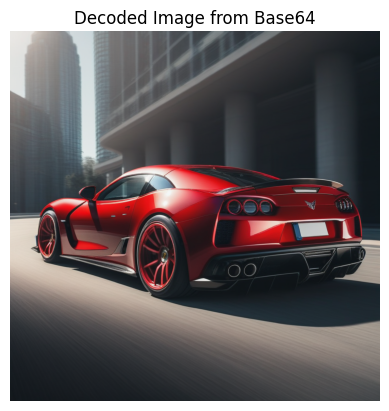

Input Prompt: A picture of
Generated Caption: A picture of car with big wheels

--- Visual Prompt Completion ---
Prompt: This is an image of a
Generated Caption: This is an image of ars

--- Generating Captions for 3 Sample Images ---

🔹 Image #1


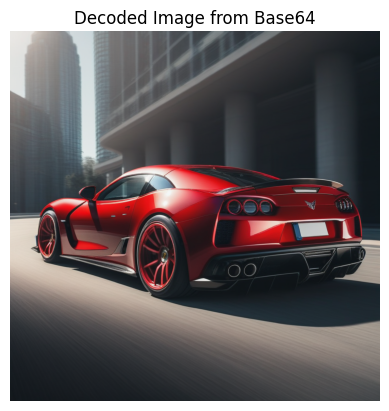

Prompt: A picture of
Generated Caption: A picture ofbiting Mars

🔹 Image #2


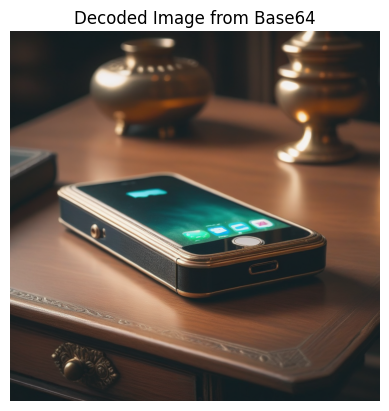

Prompt: A picture of
Generated Caption: A picture of car with big wheels

🔹 Image #3


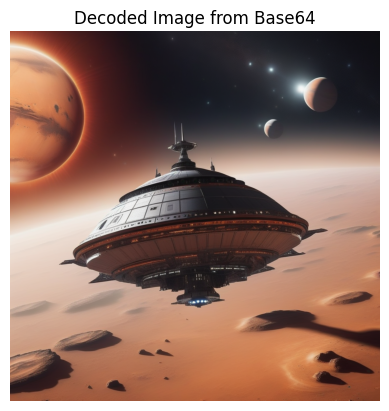

Prompt: A picture of
Generated Caption: A picture of car with big wheels


In [ ]:
# Select one sample image to test
sample_base64 = df.iloc[0]['b64string_images']

# Run individual tests
show_image_from_base64(sample_base64)
test_model_on_image(model, sample_base64)
test_visual_prompt_completion(model, sample_base64)

# Run batch test
test_multiple_images(model, df, num_samples=3)